![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Basic Image Restoration

# Original Images used in this Example:


1.   Santiago: https://flic.kr/p/VD2Pin
2.   Door: https://flic.kr/p/dmx5iU


(c) Domingo Mery

In [ ]:
!wget https://www.dropbox.com/s/w9tew0pn2259kgl/santiago.png
!wget https://www.dropbox.com/s/i62imnk7j0ot430/puerta_bw.png
!wget https://www.dropbox.com/s/z0bkrak7n5n19qg/santiago512.png

--2023-10-17 15:02:12--  https://www.dropbox.com/s/w9tew0pn2259kgl/santiago.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w9tew0pn2259kgl/santiago.png [following]
--2023-10-17 15:02:12--  https://www.dropbox.com/s/raw/w9tew0pn2259kgl/santiago.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc715f2fbca77e95fee3e7379a9f.dl.dropboxusercontent.com/cd/0/inline/CFwCDiPI7Vyt3b8Xu-OHU3AQ3Fikbju0H9_CS0IrKFLNYzh7Pp-zLTQqhClbK2pn8HlLwE4aSZEpGaYac1EE-hdYqQUBJI4jyAaSvocUIHzmKTr4avnqs1mr9C3eHJpQoGk/file# [following]
--2023-10-17 15:02:13--  https://uc715f2fbca77e95fee3e7379a9f.dl.dropboxusercontent.com/cd/0/inline/CFwCDiPI7Vyt3b8Xu-OHU3AQ3Fikbju0H9_CS0IrKFLNYzh7Pp-zLTQqhClbK2pn8HlLwE4aSZEpGaYac1EE-hdYqQUBJI4jyAaSvocUIHzmKTr4avnqs1mr9C3

# Simulation of uniform horizontal motion

In this example:



* $\bf F$: Original image
* $\bf G$: Degraded image
* $\bf \hat F$: Restored image

The degradation process consists of a horizontal uniform motion of $n$ pixels, where each row is modeled as:
$
\left[ \begin{array}{c c c c c c c}
h_1 & ... & h_n & 0   & 0   & 0   & 0   \\
0   & h_1 & ... & h_n & 0   & 0   & 0   \\
    &  :  &     &     & :   &     &     \\
0   &  0  &  ...& 0 & h_1 & ... & h_n  
\end{array} \right]
\left[ \begin{array}{c}
f_1 \\
f_2 \\
:   \\
f_M
\end{array}
\right]
=
\left[ \begin{array}{c}
g_1 \\
g_2 \\
:   \\
g_N
\end{array}
\right]
$



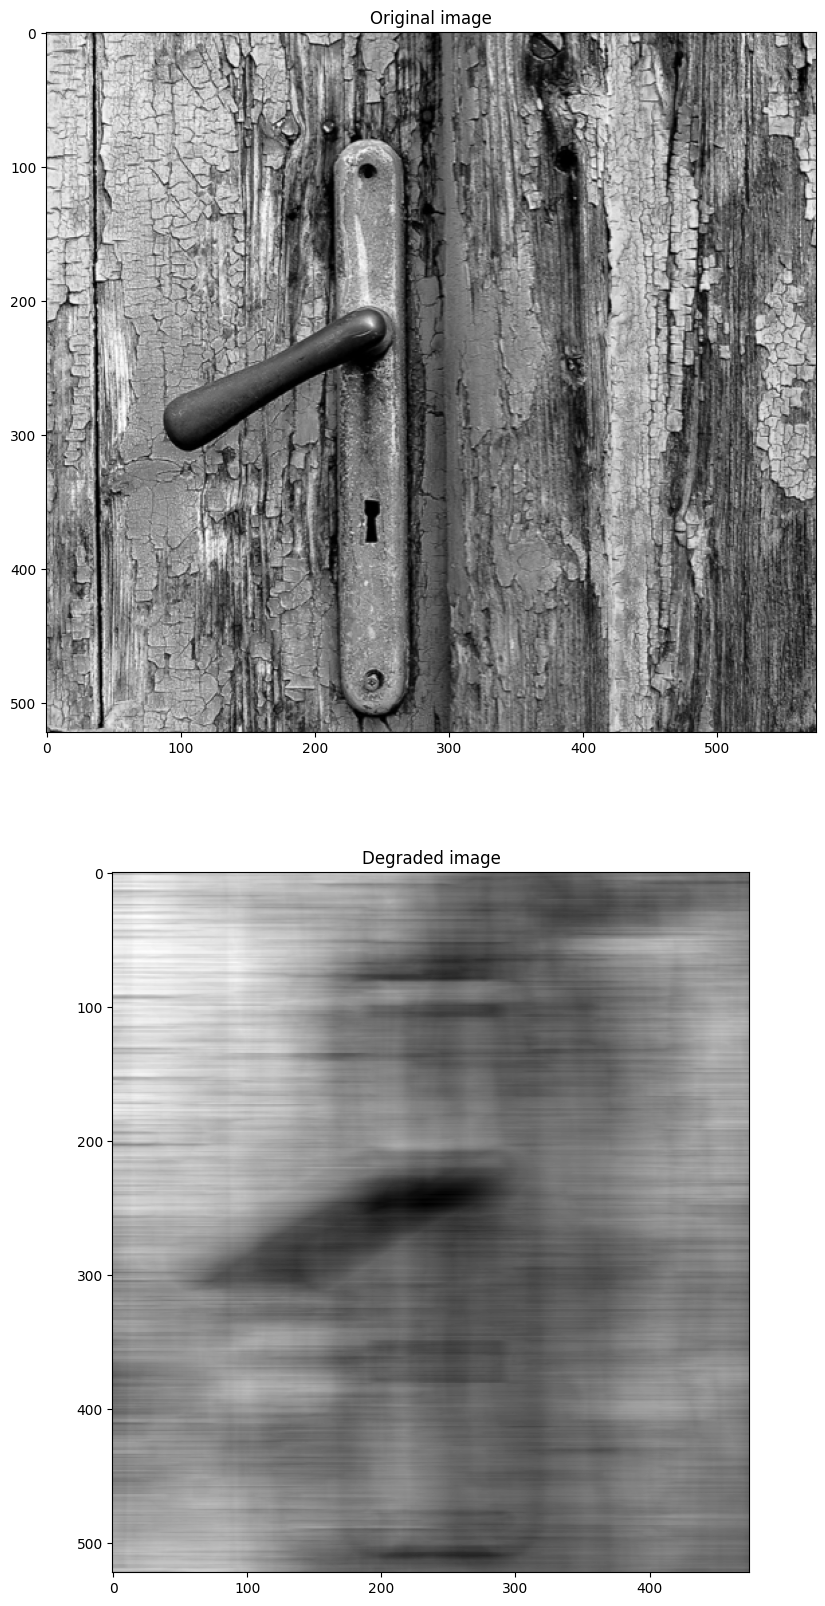

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, filter2D, IMREAD_GRAYSCALE, CV_64F

# img = imread('santiago512.png', IMREAD_GRAYSCALE)
#img = imread('santiago.png', IMREAD_GRAYSCALE)
img = imread('puerta_bw.png', IMREAD_GRAYSCALE)

n = 100
h = np.ones((1, n)) / n

N = img.shape[1]
M = N-n+1

img_g = filter2D(img.astype('double'), CV_64F, h)
img_g = img_g[:,0:M]

fig, ax = plt.subplots(2, 1, figsize=(36, 20))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('on')
ax[1].imshow(img_g, cmap='gray')
ax[1].set_title('Degraded image')
ax[1].axis('on')
plt.show()


# Restoration algorithm

The solution to this problem is obtained by minimizing the following objective function using Lagrange multipliers:

$
V({\bf f}) = \lambda\parallel{\bf H}{\bf f}-{\bf g}\parallel^2 +\parallel{\bf  W}{\bf  f}\parallel^2
$

where $\bf W$ is a regulator that reduces the ripple of ${\bf f}$. Deriving $V$ with respect to ${\bf f}$ and equaling zero we obtain:


$
{\bf \hat f} = \lambda \left[ \lambda {\bf H}^{\sf T} {\bf H} + {\bf W}^{\sf T} {\bf W} \right]^{-1} {\bf H} ^{\sf T} {\bf g}.
$

In this example, we use ${\bf W} = {\bf I}$, however, other regularization matrices can be used. In practice $10^{6}$ yields good results.

For MINIO criterium:

Mery, D.; Pieringer C. (2020): Computer Vision for X-ray Testing. Springer. 2nd Edition.

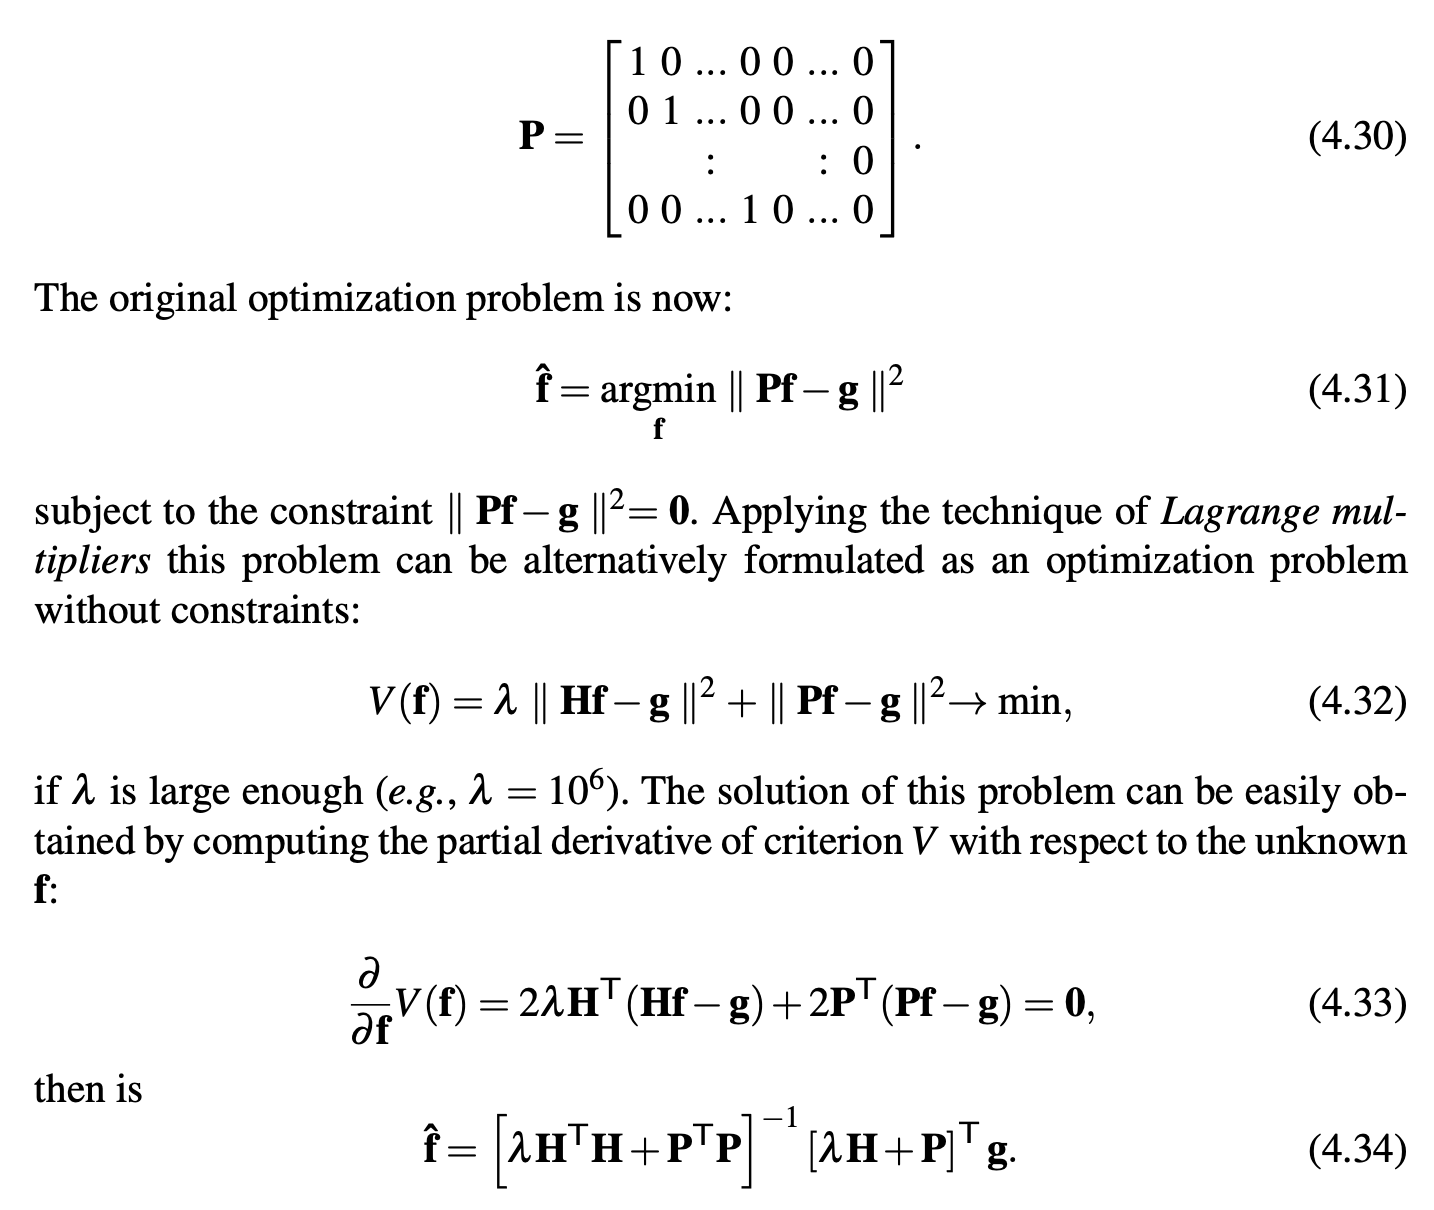

In [ ]:
def res_minio(_img_g, h, method='minio'):
    """

    Args:
        _img_g: blured image as ndarray.
        h: PSF as ndarray.
        method: integer value to select minimization method:
                'minio': ||f_n - g|| -> min
                'other': ||f|| -> min

    Returns:
        _img_f: the restored image as ndarray.

    Raises:
        ValueError: if h is not ndarray.
        Exception

    Authors:
        Christian Pieringer & Domingo Mery
        from pyxvis library.
    """

    _valid_methods = ['minio', 'eye']

    # Check input parameters
    # Input image _img_g
    if not isinstance(_img_g, np.ndarray):
        raise Exception('{} is not valid input format for the blured image _img_g.'.format(type(_img_g)))

    # PSF h
    if not isinstance(h, np.ndarray):
        raise Exception('{} is not a valid format for PSF.'.format(type(h)))

    # Method
    if method not in _valid_methods:
        raise ValueError('method do not meet {} as a valid method'.format(method))

    # Main
    nh = h.shape[-1]
    n = _img_g.shape[-1]
    m = n + nh - 1
    _mat_h = np.zeros((n, m))

    # Composing H matrix
    for i in range(n):
        _mat_h[i, i:i + nh] = h.ravel()

    _lambda = 1e6  # Lagrange multiplier

    if method == 'minio':
        _mat_p = np.hstack([np.eye(n, dtype='float'), np.zeros((n, nh - 1))])
        _img_f = _img_g @ (_lambda * _mat_h + _mat_p)
        _img_f = _img_f @ (np.linalg.inv((_lambda * _mat_h).T @ _mat_h + _mat_p.T @ _mat_p)).T

    if method =='eye':
        _img_f = _img_g @ _mat_h
        _img_f = _img_f @ (np.linalg.inv((_lambda * _mat_h).T @ _mat_h + np.eye(m, dtype='float'))).T

    # Clip the image between 0 and 255
    _img_f[_img_f < 0] = 0
    _img_f[_img_f > 255] = 255

    return _img_f


# Restoration of horizontal motion blurriness

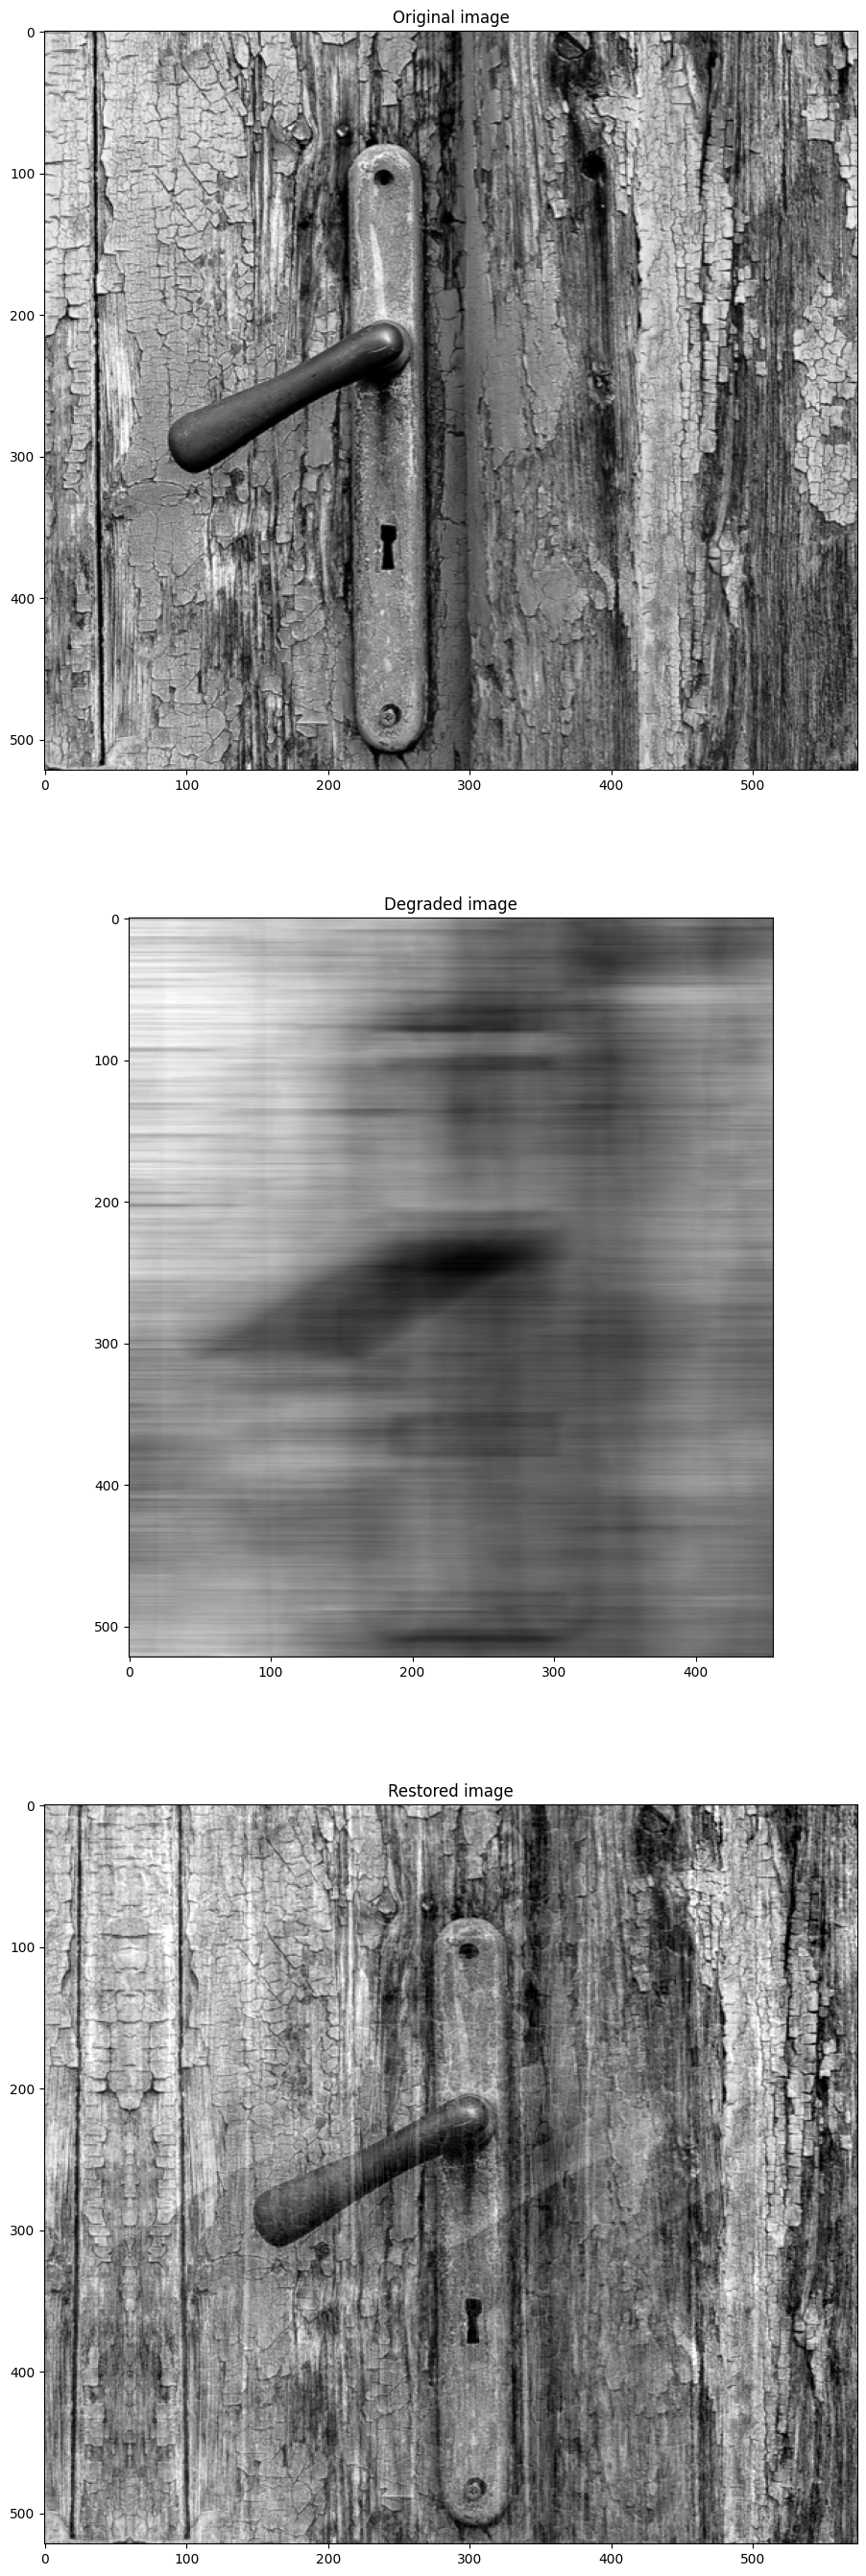

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, filter2D, IMREAD_GRAYSCALE, CV_64F

#img = imread('santiago512.png', IMREAD_GRAYSCALE)
#img = imread('santiago.png', IMREAD_GRAYSCALE)
img = imread('puerta_bw.png', IMREAD_GRAYSCALE)

# Definition of h
n = 120
h = np.ones((1, n)) / n

N = img.shape[1]
M = N-n+1

# Degraded Image
img_g = filter2D(img.astype('double'), CV_64F, h)
img_g = img_g[:,0:M]

# Restoration
fs = res_minio(img_g, h, method='minio')

fig, ax = plt.subplots(3, 1, figsize=(48, 34))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('on')
ax[1].imshow(img_g, cmap='gray')
ax[1].set_title('Degraded image')
ax[1].axis('on')
ax[2].imshow(fs, cmap='gray')
ax[2].set_title('Restored image')
ax[2].axis('on')
plt.show()


In [ ]:
a=3